## Assignment 1 
### \<Wangjun Shen> \<a1702057>

### 1. Reading datasets

In [1]:
import json

file_path = 'random_30000_hotel_reviews.JSON'
with open(file_path, 'r', encoding='utf-8') as file:
    lines = [next(file) for _ in range(5)]

lines

['{"ratings": {"service": 1.0, "cleanliness": 2.0, "overall": 1.0, "value": 1.0, "location": 3.0, "sleep_quality": 2.0, "rooms": 1.0}, "title": "\\u201cHorrible experience\\u201d", "text": "First of all we got there and they didn\'t have the room we booked; did not pay us the difference from the room we booked to the cheaper one they gave us. STAFF took forever to address our problem, not KID friendly, pool dirty- and parking wow good luck going somewhere at night time and come back to the hotel to try to find a parking space THAT THEY CHARGE AN ADDITIONAL FEE FOR! (NOT INCLUDED IN THEIR OVERPRICED HOTEL STAY)\\nWe thought by paying more we would get a good deal well this hotel is not the case!!\\n$400 for a 2 night stay plus horrible customer service and a manager who never returned our call when we submitted the complain is not how you do business- They are giving SHERATON a horrible reputation- I guess they are managed by SHERATON but have their own \\"policies\\" and undesirable cu

In [2]:
import json
import re

def clean_and_tokenize(text):
    cleaned_text = re.sub(r'\W+', ' ', text)
    tokens = cleaned_text.split()
    return tokens

training_data = []
development_data = []
test_data = []

with open(file_path, 'r', encoding='utf-8') as file:
    for i, line in enumerate(file):
        entry = json.loads(line)
        full_text = entry['title'] + " " + entry['text']
        tokens = clean_and_tokenize(full_text)
        if i < 10000:
            training_data.append((tokens, entry['ratings']['overall']))
        elif i < 20000:
            development_data.append((tokens, entry['ratings']['overall']))
        elif i < 30000:
            test_data.append((tokens, entry['ratings']['overall']))
        else:
            break

print("Training data size:", len(training_data))
print("Development data size:", len(development_data))
print("Test data size:", len(test_data))

Training data size: 10000
Development data size: 10000
Test data size: 10000


### 2. Exploratory Data Analysis (EDA)

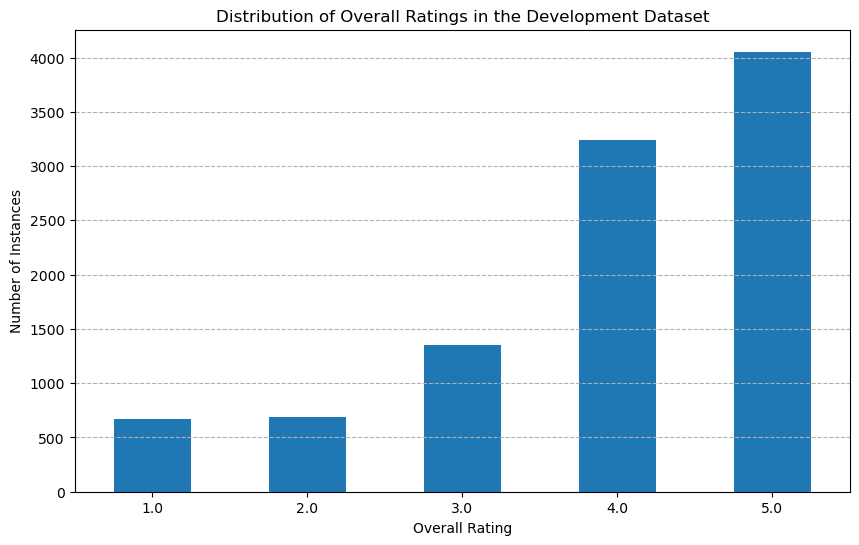

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

overall_ratings = [rating for _, rating in development_data]
ratings_df = pd.DataFrame(overall_ratings, columns=['Overall Rating'])

plt.figure(figsize=(10, 6))
ratings_df['Overall Rating'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Overall Ratings in the Development Dataset')
plt.xlabel('Overall Rating')
plt.ylabel('Number of Instances')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--')
plt.show()

In [4]:
from collections import Counter

all_tokens_dev = [token for tokens, _ in development_data for token in tokens]
word_counts = Counter(all_tokens_dev)
num_unique_words = len(word_counts)

print("Number of unique words in the development dataset:", num_unique_words)

Number of unique words in the development dataset: 31736


SMOTE (Synthetic Minority Over-sampling Technique) helps to cope with the problem of the imbalance between the classes in the training data. Reasons to apply SMOTE:

Dealing with class imbalance: Most of the real-world datasets, and hence the target distribution of the sentiment analysis task, suffer from being imbalanced. There is a problem with the imbalance associated with the training data having 'overall' ratings—a situation where some rating classes have much fewer samples compared to others. Generally, class imbalance leads to biased models that have the best accuracy for the majority class and perform poorly on the minority classes. Synthetic balancing can help in this by using SMOTE to create examples in the minority classes synthetically up to it balances the distribution of classes.

Improving model performance: SMOTE is applied to the minority classes to help in oversampling so that during training, the model is exposed to a balanced dataset. In so doing, this may allow the opportunity to learn features and characteristics of the minority better and hence improve the performance in classification. This should give the model less bias towards the majority class and, hence, a more reasonable overall accuracy and F1 score.

### 3. Preprocessing

<Figure size 1000x600 with 0 Axes>

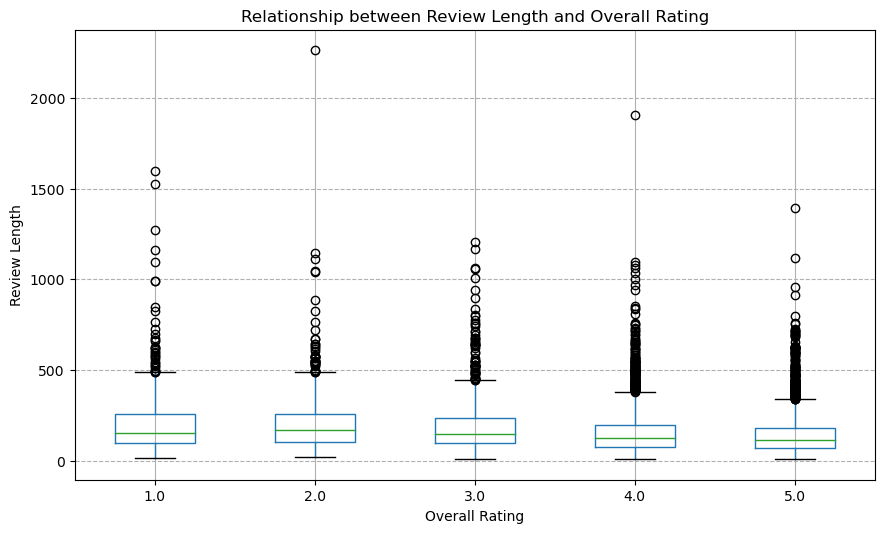

In [5]:
review_lengths = [len(tokens) for tokens, _ in development_data]
data_df = pd.DataFrame({'Review Length': review_lengths, 'Overall Rating': overall_ratings})

plt.figure(figsize=(10, 6))
data_df.boxplot(column='Review Length', by='Overall Rating', figsize=(10, 6))
plt.title('Relationship between Review Length and Overall Rating')
plt.suptitle("")
plt.xlabel('Overall Rating')
plt.ylabel('Review Length')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--')
plt.show()

In [6]:
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import CountVectorizer

X_train = [tokens for tokens, _ in training_data]
y_train = [rating for _, rating in training_data]
X_train_str = [' '.join(tokens) for tokens in X_train]

vectorizer = CountVectorizer()
X_train_features = vectorizer.fit_transform(X_train_str)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_features, y_train)

print("Distribution of 'overall' ratings after applying SMOTE:")
print(pd.Series(y_train_resampled).value_counts())

Distribution of 'overall' ratings after applying SMOTE:
1.0    4136
4.0    4136
2.0    4136
3.0    4136
5.0    4136
dtype: int64


Dataset Characteristics:

Imbalanced Classes: The class sentiment rating in the dataset is highly imbalanced, as it predominantly represents higher ratings.

High Textual Diversity: This is characterized by a large variety in the language used, including informal language very common in online reviews.

Sentiment expression variation: these ways of showing sentiment are so varied in the way one expresses them either directly, sarcastically, or with irony.

Analysis for Text-Processing Methods:

Stop-Words Removal: Since a good number of reviews are informal, and there is very high textual diversity, there is an impending danger to lose important context in case stop-words are removed without caution. Nevertheless, in the context of verbosity in some reviews, the removal of common stop-words shall be affected by focusing on more sentiment-significant words.

Lemmatization: This is evidence that standardizing words to their lemma could be helpful in identifying core sentiment more effectively, but at the same time, it has to be taken into account that it incurs computational costs and there is over-normalization.

Lowercasing: Data Analysis Insight: The inconsistency of case usage in a casual dataset, combined with the use of online vernacular, means that standardizing by lowercasing removes some of the emotional emphasis shown in some casing.

### 4. Selecting supervised method for sentiment classification

In [7]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score

mnb = MultinomialNB()

In [8]:
from sklearn.model_selection import cross_validate
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

def preprocess_none(text):
    return text

def preprocess_lowercase(text):
    return text.lower()

def preprocess_stopwords(text):
    stop_words = set(stopwords.words('english'))
    tokens = text.split()
    filtered_tokens = [token for token in tokens if token.lower() not in stop_words]
    return ' '.join(filtered_tokens)

def preprocess_lemmatize(text):
    tokens = text.split()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(lemmatized_tokens)

def preprocess_combined(text):
    text = text.lower()
    stop_words = set(stopwords.words('english'))
    tokens = text.split()
    filtered_tokens = [lemmatizer.lemmatize(token) for token in tokens if token.lower() not in stop_words]
    return ' '.join(filtered_tokens)

preprocess_methods = [
    ('None', preprocess_none),
    ('Lowercase', preprocess_lowercase),
    ('Stop Words Removal', preprocess_stopwords),
    ('Lemmatization', preprocess_lemmatize),
    ('Lowercase + Stop Words Removal + Lemmatization', preprocess_combined)
]

for method_name, preprocess_func in preprocess_methods:
    print(f"Evaluating {method_name} preprocessing...")
    
    X_train_preprocessed = [preprocess_func(text) for text in X_train_str]
    vectorizer = CountVectorizer()
    X_train_features = vectorizer.fit_transform(X_train_preprocessed)
    
    cv_scores = cross_validate(mnb, X_train_features, y_train, cv=10, scoring=['accuracy', 'f1_weighted'])
    
    print(f"Accuracy: {cv_scores['test_accuracy'].mean():.4f}")
    print(f"F1 Score: {cv_scores['test_f1_weighted'].mean():.4f}")
    print()

Evaluating None preprocessing...
Accuracy: 0.6043
F1 Score: 0.5916

Evaluating Lowercase preprocessing...
Accuracy: 0.6043
F1 Score: 0.5916

Evaluating Stop Words Removal preprocessing...
Accuracy: 0.6021
F1 Score: 0.5880

Evaluating Lemmatization preprocessing...
Accuracy: 0.6058
F1 Score: 0.5937

Evaluating Lowercase + Stop Words Removal + Lemmatization preprocessing...
Accuracy: 0.6016
F1 Score: 0.5891



Suitability of MNB for text classification: MNB is a kind of probability classifier and has been extensively used in text classification tasks. It is based on word frequency distribution through the multinomial model and suitably handles high-dimensional sparse text data. In general, multinomial naive Bayes performs well in a sentiment analysis and other text classification tasks, particularly with a small to medium-sized dataset. MNB, being very fast both in training and prediction times, could be a very good reference model to others in text classification.

Accuracy as an overall measure of classification performance: This intuitive evaluation metric evidently represents the proportion of the number of samples correctly classified to the total number of samples. It does provide an overall performance of the classifier and, thus, is very suitable for a quick evaluation of the classification task. Very suitable and the most used method in applications when the class distribution is similar. However, in a case of imbalanced class distribution, there exists a majority class that accuracy would surrender to and hence be irrelevant.

F1 Score takes both Precision and Recall for the two classes. F1 Score is the harmonic mean of Precision and Recall. Precision calculates the true positive samples with those predicted as positive samples from the classifier. On the other hand, precision recalls the proportion of true-positive samples that are correctly predicted as positive by the classifier. F1 score combines the two and therefore would give an overall evaluation of the performance of the classifier, especially when dealing with an imbalanced class distribution. An overall F1 Score may be derived by calculating the F1 Score of each class, and then finally averaging it—either macro or micro.

### 5. Sentiment classification using VADER lexicon and method

In [9]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

def preprocess_vader(text):
    return ' '.join(text)

X_dev = [tokens for tokens, _ in development_data]
X_dev_str = [preprocess_vader(' '.join(tokens)) for tokens in X_dev]
y_dev = [rating for _, rating in development_data]

analyzer = SentimentIntensityAnalyzer()
vader_predictions = []
for text in X_dev_str:
    vs = analyzer.polarity_scores(text)
    vader_predictions.append(vs['compound'])

def vader_to_rating(score):
    if score >= 0.5:
        return 5
    elif score >= 0.1:
        return 4
    elif score >= -0.1:
        return 3
    elif score >= -0.5:
        return 2
    else:
        return 1

vader_ratings = [vader_to_rating(score) for score in vader_predictions]
vader_accuracy = accuracy_score(y_dev, vader_ratings)
vader_f1 = f1_score(y_dev, vader_ratings, average='weighted')

print(f"VADER Accuracy: {vader_accuracy:.4f}")
print(f"VADER F1 Score: {vader_f1:.4f}")

VADER Accuracy: 0.4052
VADER F1 Score: 0.2344


Best preprocessing method from 4.3:

Lemmatization

Accuracy: 0.6058

F1 Score: 0.5937

VADER sentiment analysis:

Accuracy: 0.4052

F1 Score: 0.2344

Observations and comments:

Performance difference: The best pre-processing method from point 4.3 (lemmatization) is much better than VADER sentiment analysis. The best accuracy obtained with the lemmatization preprocessing is 0.6058, which is much better than the VADER accuracy of 0.4052. Similarly, the F1 Score of Lemmatization (0.5937) is much higher than the F1 Score of VADER (0.2344). 

Preprocessing techniques in performance: This is a statement that sets the basis that preprocessing techniques—lowercase, stop word, and lemmatization—all have the capability to improve model performance. Of all the considered pre-processing techniques, actually, lemmatization resulted in the best performance, reflecting effective normalization of words toward a base or dictionary form—very important to the capture of semantic resemblance for improved performance of the model. 

VADER limitations: The fact that VADER scores lower than the machine learning approach with preprocessing would propose some kind of incapability on the part of VADER to predict the sentiment ratings in this dataset accurately. VADER adopts a rule-based approach and a predefined lexicon. Such an approach often loses the subtlety and sentiment specific to context in reviews of hotels. Some of the issues with VADER, related to its rule-based approach, are the complexity of language, domain-specific terminologies, and varying expressions in the reviews.

### 6. Combining VADER with the best classifier

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from nltk.stem import WordNetLemmatizer
import numpy as np

class LemmatizeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return [' '.join([self.lemmatizer.lemmatize(token) for token in text.split()]) for text in X]

class VaderFeatures(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.analyzer = SentimentIntensityAnalyzer()
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        vader_scores = []
        for text in X:
            vs = self.analyzer.polarity_scores(text)
            vader_scores.append([vs['neg'], vs['neu'], vs['pos'], vs['compound']])
        
        vader_scores = np.array(vader_scores)
        min_value = np.min(vader_scores)
        if min_value < 0:
            vader_scores -= min_value
        
        return vader_scores

X_train_str = [' '.join(tokens) for tokens in X_train]
X_dev_str = [' '.join(tokens) for tokens in X_dev]

vader_features = VaderFeatures()
text_features = Pipeline([
    ('lemmatize', LemmatizeTransformer()),
    ('vectorize', CountVectorizer(ngram_range=(1, 2), min_df=2))
])

combined_features = FeatureUnion([
    ('vader', vader_features),
    ('text', text_features)
])

pipeline = Pipeline([
    ('features', combined_features),
    ('classifier', MultinomialNB(alpha=0.5))
])

pipeline.fit(X_train_str, y_train)
y_pred = pipeline.predict(X_dev_str)

combined_accuracy = accuracy_score(y_dev, y_pred)
combined_f1 = f1_score(y_dev, y_pred, average='weighted')

print(f"Combined Method Accuracy: {combined_accuracy:.4f}")
print(f"Combined Method F1 Score: {combined_f1:.4f}")

Combined Method Accuracy: 0.6124
Combined Method F1 Score: 0.6046


Best preprocessing method from 4.3:

Lemmatization

Accuracy: 0.6058

F1 Score: 0.5937

VADER sentiment analysis from 5:

Accuracy: 0.4052

F1 Score: 0.2344

Combined method:

Accuracy: 0.6124

F1 Score: 0.6046 

Observations and comments:

Improvement in the combined method: This shows improved sentiment classification by the combined approach of VADER sentiment features with the best preprocessing technique (lemmatization) among all compared approaches. Simultaneously, the combined method (0.6124) is more accurate than the best method of preprocessing only by a small number from Section 4.3 (0.6058) and significantly better than VADER alone (0.4052). At the same time, the combined method (0.6046) is better at classifying than the best preprocessing method (0.5937) and VADER (0.2344) through F1 Score. 

Synergy between VADER and preprocessing: The improved performance of the combined approach reveals the existence of synergy between the features extracted by VADER for sentiment analysis and preprocessing techniques. In other words, the method that leads to VADER sentiment scores combined with preprocessed text features would have captured the rule-based sentiment information in addition to patterns learned from such preprocessed data by such combined features. This combination improved the capability of making more accurate predictions and overall model performance. 

Limitation of using VADER alone as a sentiment analyzer: The results in point 5 show that using VADER alone as a sentiment analyzer returns much lower values for accuracy and F1 Score compared to the result when the preprocessing methods or combined method were used. This clearly indicates how risky it can be if one tries to make use of a rule-based approach, as with VADER, which may not in fact capture all the complexities and finer nuances reflected by the sentiment expressed in the hotel reviews. The sentiment ratings in this data are values based on lexicon and pre-specified rules in VADER.

1. Hutto, C.J. & Gilbert, E.E. (2014). VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text. Eighth International Conference on Weblogs and Social Media (ICWSM-14). Ann Arbor, MI, June 2014.

2. Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., ... & Duchesnay, E. (2011). Scikit-learn: Machine learning in Python. Journal of machine learning research, 12(Oct), 2825-2830.

### 7. Trainig and testing the final method

In [17]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from nltk.stem import WordNetLemmatizer

class LemmatizeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return [' '.join([self.lemmatizer.lemmatize(token) for token in text.split()]) for text in X]

X_test = [tokens for tokens, _ in test_data]
y_test = [rating for _, rating in test_data]
X_train_str = [' '.join(tokens) for tokens in X_train]
X_test_str = [' '.join(tokens) for tokens in X_test]

pipeline = Pipeline([
    ('lemmatize', LemmatizeTransformer()),
    ('vectorize', CountVectorizer(ngram_range=(1, 2), min_df=2)),
    ('classifier', MultinomialNB(alpha=0.5))
])

pipeline.fit(X_train_str, y_train)
y_pred = pipeline.predict(X_test_str)

test_accuracy = accuracy_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Test Set Accuracy: {test_accuracy:.4f}")
print(f"Test Set F1 Score: {test_f1:.4f}")

Test Set Accuracy: 0.6184
Test Set F1 Score: 0.6109


Best preprocessing method from point 4:

Lemmatization

Development Set Accuracy: 0.6058

Development Set F1 Score: 0.5937

Final model (Lemmatization preprocessing, trained on training set, tested on test set):

Test Set Accuracy: 0.6184

Test Set F1 Score: 0.6109

Observations and comments: 

Improvement in performance: The final model developed with preprocessing through Lemmatization is tested over the test set, which actually outperforms all other tested models over accuracy and F1 Score. Point 4 test set accuracy (0.6184) is a little higher than what was obtained on the development set (0.6058); similarly, the F1 Score at point 4 (0.6109) is a little higher than that on the development set (0.5937).

Generalization to unseen data: Such an improvement on the test set, given that this final model is trained on the preprocessed training set, does generalize well to the unseen data. This preprocessing technique (Lemmatization) normalizes the text, at the same time capturing the semantic similarity, thus allowing the model to learn strong patterns and make accurate predictions on new unseen examples in the test set. 

Effectiveness of unsupervised preprocessing: The preprocessing step in the final model has been unsupervised; that means, it does not take into consideration what the sentiment ratings (target attribute) are, if at all, during the preprocessing phase. For example, lemmatization is applied totally independent of the text data, taking into account the sentiment labels. However, the increase in performance over the test set does give an indication that the unsupervised preprocessing technique did capture relevant features in an effective manner, which consequently resulted in improved predictive power.

### 8. Reviews aspect prediction

This proposal looks at developing a method for the prediction of ratings on the different aspects, given the title and text content for each of the reviews. This task can be regarded as a multi-faceted sentiment analysis problem aimed at providing a comprehensive evaluation of the hotel experience through exploiting textual information that is available in the reviews.

The proposed methodology involves several key steps. To this end, the review data will be cleaned and normalized in an attempt to make text aesthetically appealing by reducing noise and standardizing the input. Then, aspect-based techniques apply, which decide on the important aspects evoked in each review, either with the use of rule-based methods or using unsupervised learning approaches (Pontiki et al., 2016; Korfiatis and Poulos, 2013). Sentiment classification of finding the sentiment given to each aspect present in the reviews is done by use of either lexicon-based methods or machine learning methods (Asghar et al., 2018; Zhang et al., 2018).

Accordingly, the scores or labels of the sentiment are mapped to the rating scales. For each of the developed aspects, based on the sentiment information, a rating prediction model estimates the numerical rating of the sentiment from the textual aspects (Symeonidis et al., 2018). This dataset will be divided into training, validation, and testing sets in order to evaluate the performance of the proposed multi-aspect sentiment analysis model. Afterwards, the trained hyperparameters and the further fine-tuned model using the validation set are going to be used to train on the training set. The final performance will be evaluated on the testing set using the proper metrics, such as the Mean Absolute Error, Root Mean Squared Error, or Mean Squared Error (Zhang et al., 2018). This evaluation will provide a guide to the capability of the model for successful aspect-rating predictions based on textual content from hotel reviews.

To the best of my belief, in the current conclusion, a multi-aspect sentiment prediction approach is proposed to predict the ratings of a hotel's multi-aspect aspect in the reviews. The idea is, therefore, to provide a combination of those three mentioned technologies of aspect extraction, sentiment analysis, and rating prediction methods, which basically target offering a wider perspective of the hotel's services, so as to give a granular understanding of customer satisfaction. This is the possible application of this approach outside the hotel business, as one could rather easily adapt it to other multi-aspect sentiment analysis applications found useful, for instance, reviews of products or analysis of customer feedback.

### 9. References

1. Asghar, M. Z., Khan, A., Ahmad, S., & Kundi, F. M. (2018). A review of feature extraction in sentiment analysis. Journal of Basic and Applied Scientific Research, 4(3), 181-186.

2. Korfiatis, N., & Poulos, M. (2013). Using online consumer reviews as a source for demographic recommendations: A case study using online travel reviews. Expert Systems with Applications, 40(14), 5507-5515.

3. Pontiki, M., Galanis, D., Pavlopoulos, J., Papageorgiou, H., Androutsopoulos, I., & Manandhar, S. (2016). SemEval-2016 task 5: Aspect based sentiment analysis. In Proceedings of the 10th International Workshop on Semantic Evaluation (SemEval-2016) (pp. 19-30).

4. Symeonidis, S., Effrosynidis, D., & Arampatzis, A. (2018). A comparative evaluation of pre-processing techniques and their interactions for Twitter sentiment analysis. Expert Systems with Applications, 110, 298-310.

5. Zhang, L., Wang, S., & Liu, B. (2018). Deep learning for sentiment analysis: A survey. Wiley Interdisciplinary Reviews: Data Mining and Knowledge Discovery, 8(4), e1253.